In [1]:
import pandas as pd #數據處理
import numpy as np  #隨機取數
import matplotlib.pyplot as plt   #繪圖
#把繪圖套入ipython中的魔法函數%
%matplotlib inline  
plt.rcParams['figure.figsize'] = 7,7   # 圖片大小
plt.rcParams['font.size'] = 14         # 圖片文字大小

In [2]:
# 建立數據集
from sklearn.datasets import make_circles
#n_samples---返回數據數量
#noise ---高斯模糊片差
#shuffle ---洗牌樣品
#factor --- 內圈外圈比例
X, y = make_circles(
    n_samples = 6000, noise = 0.1, 
    shuffle = True, factor = .65
)
#將參數變成表格(二維)
X = pd.DataFrame(X, columns = ['feature1', 'feature2'])
y = pd.Series(y) #將參數放入一個一維的list
X,y

(      feature1  feature2
 0    -0.637425 -0.781475
 1     0.645435  0.369957
 2     0.495787  0.932067
 3     1.022387 -0.295245
 4     0.091150  1.217321
 5    -0.562768 -0.099986
 6     0.639535  0.979610
 7    -0.928115 -0.239816
 8    -0.657011  0.633261
 9    -0.356475  0.696385
 10    0.674569  0.042247
 11   -0.269489 -0.508260
 12    0.572933 -0.301841
 13   -0.528845  0.194185
 14   -0.097528  0.499408
 15   -0.301321 -0.454222
 16   -0.390284  0.095746
 17    0.467399 -1.007544
 18   -0.575329  0.447721
 19    0.107029  0.481866
 20   -0.776834 -0.122877
 21   -0.694274 -0.581368
 22    0.246779 -0.539045
 23    0.491437  0.981757
 24   -0.841474 -0.175269
 25    0.152800 -1.012932
 26    0.309381 -0.665699
 27    0.956404  0.326752
 28   -1.122744  0.332227
 29    1.185712  0.254412
 ...        ...       ...
 5970  0.494149  0.160194
 5971 -0.455974  0.509530
 5972  0.610888  0.861789
 5973  0.128741 -0.963581
 5974 -0.254454 -0.904258
 5975 -0.492987  0.418221
 5976  0.373

In [3]:
# 保留原本的標籤，之後比對使用
y_orig = y.copy()

# 取消一些標記的數據
hidden_size = 2700
#loc可以選擇數據(把上面數量的POSTIVE DATA隱藏為UNLABELED DATA)
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

In [4]:
type(y)

pandas.core.series.Series

In [5]:
# 使用一般的隨機森林算法
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  # 使用1000顆決策樹
    n_jobs = -1           # 使用全部的CPU合運算
)
rf.fit(X, y)

# 儲存次方法給定的分數
results = pd.DataFrame({
    'truth'      : y_orig,   # 真實標籤
    'label'      : y,        # 預測標籤
    'output_std' : rf.predict_proba(X)[:,1],   # 隨機森林分數(求屬於標籤1的概率)
}, columns = ['truth', 'label', 'output_std'])
print(results)

      truth  label  output_std
0         0      0       0.000
1         1      0       0.006
2         0      0       0.000
3         0      0       0.003
4         0      0       0.001
5         1      0       0.000
6         0      0       0.000
7         0      0       0.000
8         0      0       0.003
9         1      0       0.084
10        1      0       0.115
11        1      0       0.008
12        1      0       0.009
13        1      0       0.000
14        1      0       0.019
15        1      0       0.002
16        1      0       0.012
17        0      0       0.000
18        1      0       0.010
19        1      0       0.013
20        0      0       0.027
21        0      0       0.000
22        1      0       0.026
23        0      0       0.000
24        1      0       0.000
25        0      0       0.000
26        1      0       0.071
27        0      0       0.000
28        0      0       0.000
29        0      0       0.000
...     ...    ...         ...
5970    

In [6]:
ts = range(100, hidden_size, 100)
y_std, y_bag, y_skb, y_stp, y_all = [], [], [], [], []
for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )

In [7]:
 results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(100).truth.mean()

0.95

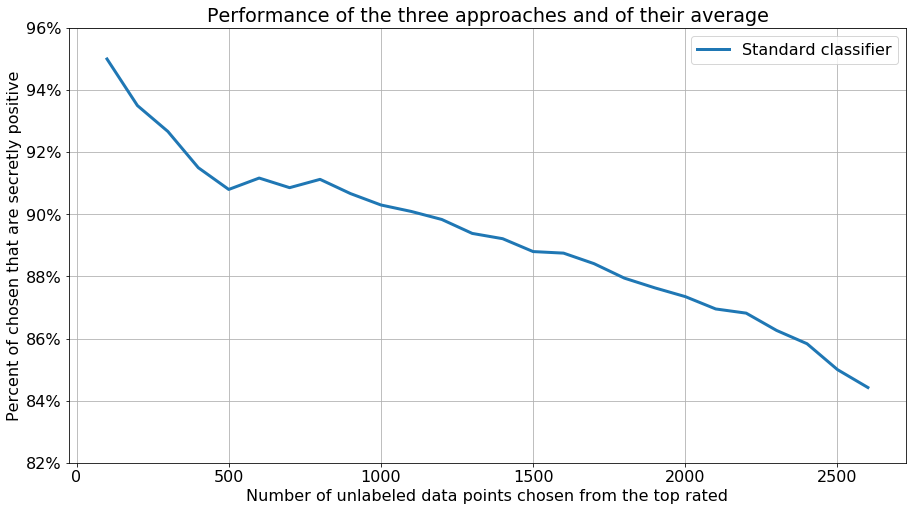

In [8]:
# 效能圖
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8

plt.plot(
    ts, y_std,
    lw = 3
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly positive')
plt.legend([
    'Standard classifier'
])
ylim = plt.gca().get_ylim()
plt.title('Performance of the three approaches and of their average')
plt.grid()
plt.show()

In [9]:
# 使用1000棵決策樹
from sklearn.tree import DecisionTreeClassifier
n_estimators = 1000
estimator = DecisionTreeClassifier()

# 追蹤正實例和未標記實例的索引
iP = y[y > 0].index
iU = y[y <= 0].index

# 對每個數據點記錄他是OOB的次數
num_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

# 記錄OOB分數的總合
sum_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

for _ in range(n_estimators):
    # 獲取本輪未標記點的 bootstrap sample(引導樣本)
    ib = np.random.choice(iU, replace=True, size = len(iP))

    # 找到本輪的OOB數據
    i_oob = list(set(iU) - set(ib))

    # 獲取訓練數據 (所有正實例和 bootstrap sample(未標記實例)還有建立樹
    Xb = X[y > 0].append(X.loc[ib])
    yb = y[y > 0].append(y.loc[ib])
    estimator.fit(Xb, yb)
    
    # 紀錄本輪OOB分數還有OOB次數
    sum_oob.loc[i_oob, 0] += estimator.predict_proba(X.loc[i_oob])[:,1]
    num_oob.loc[i_oob, 0] += 1

# 最後儲存平均的OOB分數
results['output_bag'] = sum_oob / num_oob
print(results)

      truth  label  output_std  output_bag
0         0      0       0.000    0.185729
1         1      0       0.006    0.482686
2         0      0       0.000    0.000000
3         0      0       0.003    0.008421
4         0      0       0.001    0.000000
5         1      0       0.000    0.349576
6         0      0       0.000    0.000000
7         0      0       0.000    0.000000
8         0      0       0.003    0.080084
9         1      0       0.084    0.902232
10        1      0       0.115    0.914467
11        1      0       0.008    0.611579
12        1      0       0.009    0.638567
13        1      0       0.000    0.309904
14        1      0       0.019    0.667016
15        1      0       0.002    0.548218
16        1      0       0.012    0.573093
17        0      0       0.000    0.004145
18        1      0       0.010    0.563351
19        1      0       0.013    0.649104
20        0      0       0.027    0.735511
21        0      0       0.000    0.157219
22        1

In [34]:
X[y > 0]

,feature1,feature2
47,-0.183176,-0.766261
48,-0.495459,-0.494375
51,0.568555,-0.377633
55,-0.715876,0.492129
101,-0.824164,-0.016866
103,0.298503,-0.483666
127,0.552798,-0.368771
142,-0.616950,0.126299
149,0.170432,-0.759847
250,-0.819352,0.117508


In [35]:
X.loc[ib]

,feature1,feature2
4316,0.170314,-0.826544
3096,-0.756905,-0.651009
4217,-0.655795,0.034224
4979,0.601332,-0.440610
5324,0.976613,0.436999
3253,0.452416,0.442020
5488,-0.790008,-0.894670
2346,-0.876494,0.560645
5072,0.972671,0.179479
3578,-0.002253,-0.899402


,feature1,feature2
0,-0.637425,-0.781475
1,0.645435,0.369957
2,0.495787,0.932067
3,1.022387,-0.295245
4,0.091150,1.217321
5,-0.562768,-0.099986
6,0.639535,0.979610
7,-0.928115,-0.239816
8,-0.657011,0.633261
9,-0.356475,0.696385
